## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(input_layer)
            
            x = keras.layers.BatchNormalization()(x)
            
        else:
            x = keras.layers.Dense(units=n_units, activation='relu', name='hidden_layer'+str(i+1))(x)
            
            x = keras.layers.BatchNormalization()(x)
            
    out = keras.layers.Dense(units=output_units, activation='softmax', name='output')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1, 0.25, 0.5, 0.75, 0.9]
redice_lr_patient = [1, 3, 5, 7, 9]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr = 1e-12,
                                  monitor='val_loss',
                                  patient=reduce_patient,
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 1
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
b

Epoch 11/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.3310 - accuracy: 0.5346 - val_loss: 1.4968 - val_accuracy: 0.4672
Epoch 12/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.3066 - accuracy: 0.5453 - val_loss: 1.4857 - val_accuracy: 0.4738
Epoch 13/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.2855 - accuracy: 0.5548 - val_loss: 1.4806 - val_accuracy: 0.4789
Epoch 14/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.2643 - accuracy: 0.5593 - val_loss: 1.4860 - val_accuracy: 0.4703
Epoch 15/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.2433 - accuracy: 0.5673 - val_loss: 1.4663 - val_accuracy: 0.4836
Epoch 16/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.2241 - accuracy: 0.5743 - val_loss: 1.4619 - val_accuracy: 0.4848
Epoch 17/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.2065 - accuracy: 0.5800

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.2197 - accuracy: 0.2655 - val_loss: 2.1351 - val_accuracy: 0.2120
Epoch 2/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.7632 - accuracy: 0.3881 - val_loss: 1.9837 - val_accuracy: 0.3010
Epoch 3/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.6339 - accuracy: 0.4284 - val_loss: 1.8201 - val_accuracy: 0.3789
Epoch 4/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.5579 - accuracy: 0.4552 - val_loss: 1.7198 - val_accuracy: 0.4059
Epoch 5/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.5034 - accuracy: 0.4739 - val_loss: 1.6398 - val_accuracy: 0.4345
Epoch 6/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.4598 - accuracy: 0.4888 - val_loss: 1.5838 - val_accuracy: 0.4464
Epoch 7/25
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 115us/step - loss: 1.1364 - accuracy: 0.6088 - val_loss: 1.4578 - val_accuracy: 0.4828
Epoch 21/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.1187 - accuracy: 0.6156 - val_loss: 1.4436 - val_accuracy: 0.4965
Epoch 22/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.1001 - accuracy: 0.6215 - val_loss: 1.4389 - val_accuracy: 0.4959
Epoch 23/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.0825 - accuracy: 0.6308 - val_loss: 1.4501 - val_accuracy: 0.4921
Epoch 24/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.0654 - accuracy: 0.6367 - val_loss: 1.4482 - val_accuracy: 0.4938
Epoch 25/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.0511 - accuracy: 0.6409 - val_loss: 1.4460 - val_accuracy: 0.4979
Numbers of exp: 5, reduce_factor: 0.25, reduce_patient: 1
Model: "model_6"
___________________________________________

Epoch 5/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.5041 - accuracy: 0.4735 - val_loss: 1.6512 - val_accuracy: 0.4153
Epoch 6/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.4621 - accuracy: 0.4876 - val_loss: 1.5947 - val_accuracy: 0.4338
Epoch 7/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.4253 - accuracy: 0.5002 - val_loss: 1.5642 - val_accuracy: 0.4446
Epoch 8/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.3951 - accuracy: 0.5113 - val_loss: 1.5153 - val_accuracy: 0.4629
Epoch 9/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.3649 - accuracy: 0.5212 - val_loss: 1.5080 - val_accuracy: 0.4635
Epoch 10/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.3375 - accuracy: 0.5332 - val_loss: 1.4992 - val_accuracy: 0.4667
Epoch 11/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.3124 - accuracy: 0.5418 - va

Epoch 25/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.0549 - accuracy: 0.6394 - val_loss: 1.4359 - val_accuracy: 0.4979
Numbers of exp: 8, reduce_factor: 0.25, reduce_patient: 7
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_26 (Batc (None, 256)               1024      
__________________________________________________

Epoch 10/25
50000/50000 [==============================] - 6s 111us/step - loss: 1.3303 - accuracy: 0.5366 - val_loss: 1.4979 - val_accuracy: 0.4726
Epoch 11/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.3053 - accuracy: 0.5459 - val_loss: 1.4819 - val_accuracy: 0.4771
Epoch 12/25
50000/50000 [==============================] - 6s 112us/step - loss: 1.2817 - accuracy: 0.5548 - val_loss: 1.4768 - val_accuracy: 0.4818
Epoch 13/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.2574 - accuracy: 0.5616 - val_loss: 1.4707 - val_accuracy: 0.4841
Epoch 14/25
50000/50000 [==============================] - 5s 110us/step - loss: 1.2397 - accuracy: 0.5689 - val_loss: 1.4616 - val_accuracy: 0.4861
Epoch 15/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.2167 - accuracy: 0.5790 - val_loss: 1.4670 - val_accuracy: 0.4809
Epoch 16/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.1961 - accuracy: 0.5861

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 116us/step - loss: 2.2284 - accuracy: 0.2700 - val_loss: 2.1502 - val_accuracy: 0.2035
Epoch 2/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.7641 - accuracy: 0.3830 - val_loss: 2.0076 - val_accuracy: 0.2893
Epoch 3/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.6352 - accuracy: 0.4260 - val_loss: 1.8602 - val_accuracy: 0.3447
Epoch 4/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.5628 - accuracy: 0.4527 - val_loss: 1.7366 - val_accuracy: 0.3833
Epoch 5/25
50000/50000 [==============================] - 5s 108us/step - loss: 1.5097 - accuracy: 0.4703 - val_loss: 1.6340 - val_accuracy: 0.4308
Epoch 6/25
50000/50000 [==============================] - 5s 109us/step - loss: 1.4668 - accuracy: 0.4860 - val_loss: 1.5819 - val_accuracy: 0.4397
Epoch 7/25
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 11s 220us/step - loss: 1.1161 - accuracy: 0.6151 - val_loss: 1.4442 - val_accuracy: 0.4968
Epoch 21/25
50000/50000 [==============================] - 11s 228us/step - loss: 1.0979 - accuracy: 0.6234 - val_loss: 1.4394 - val_accuracy: 0.4930
Epoch 22/25
50000/50000 [==============================] - 12s 233us/step - loss: 1.0808 - accuracy: 0.6289 - val_loss: 1.4407 - val_accuracy: 0.4985
Epoch 23/25
50000/50000 [==============================] - 11s 221us/step - loss: 1.0628 - accuracy: 0.6362 - val_loss: 1.4409 - val_accuracy: 0.4945
Epoch 24/25
50000/50000 [==============================] - 11s 218us/step - loss: 1.0460 - accuracy: 0.6429 - val_loss: 1.4460 - val_accuracy: 0.4962
Epoch 25/25
50000/50000 [==============================] - 11s 221us/step - loss: 1.0290 - accuracy: 0.6492 - val_loss: 1.4434 - val_accuracy: 0.4930
Numbers of exp: 13, reduce_factor: 0.50, reduce_patient: 7
Model: "model_14"
___________________________________

50000/50000 [==============================] - 6s 117us/step - loss: 1.5569 - accuracy: 0.4547 - val_loss: 1.6985 - val_accuracy: 0.4155
Epoch 5/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.5032 - accuracy: 0.4744 - val_loss: 1.6158 - val_accuracy: 0.4398
Epoch 6/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4612 - accuracy: 0.4887 - val_loss: 1.5765 - val_accuracy: 0.4488
Epoch 7/25
50000/50000 [==============================] - 6s 123us/step - loss: 1.4236 - accuracy: 0.5018 - val_loss: 1.5375 - val_accuracy: 0.4599
Epoch 8/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.3913 - accuracy: 0.5135 - val_loss: 1.5078 - val_accuracy: 0.4692
Epoch 9/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.3632 - accuracy: 0.5241 - val_loss: 1.5036 - val_accuracy: 0.4691
Epoch 10/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.3359 - accuracy: 0.5356 - val_loss: 1.49

Epoch 24/25
50000/50000 [==============================] - 8s 151us/step - loss: 1.0574 - accuracy: 0.6378 - val_loss: 1.4588 - val_accuracy: 0.4908
Epoch 25/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.0407 - accuracy: 0.6466 - val_loss: 1.4452 - val_accuracy: 0.4912
Numbers of exp: 16, reduce_factor: 0.75, reduce_patient: 3
Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_49 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_______________________________

50000/50000 [==============================] - 6s 129us/step - loss: 1.3886 - accuracy: 0.5137 - val_loss: 1.5257 - val_accuracy: 0.4620
Epoch 9/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.3598 - accuracy: 0.5252 - val_loss: 1.4994 - val_accuracy: 0.4676
Epoch 10/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.3330 - accuracy: 0.5353 - val_loss: 1.4992 - val_accuracy: 0.4685
Epoch 11/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.3095 - accuracy: 0.5421 - val_loss: 1.4808 - val_accuracy: 0.4766
Epoch 12/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.2849 - accuracy: 0.5535 - val_loss: 1.4652 - val_accuracy: 0.4817
Epoch 13/25
50000/50000 [==============================] - 8s 162us/step - loss: 1.2619 - accuracy: 0.5610 - val_loss: 1.4716 - val_accuracy: 0.4774
Epoch 14/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.2417 - accuracy: 0.5689 - val_loss: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 211us/step - loss: 2.2449 - accuracy: 0.2668 - val_loss: 2.1403 - val_accuracy: 0.2104
Epoch 2/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.7678 - accuracy: 0.3845 - val_loss: 2.0076 - val_accuracy: 0.2970
Epoch 3/25
50000/50000 [==============================] - 9s 178us/step - loss: 1.6381 - accuracy: 0.4259 - val_loss: 1.8638 - val_accuracy: 0.3620
Epoch 4/25
50000/50000 [==============================] - 9s 189us/step - loss: 1.5648 - accuracy: 0.4526 - val_loss: 1.7393 - val_accuracy: 0.4021
Epoch 5/25
50000/50000 [==============================] - 10s 198us/step - loss: 1.5085 - accuracy: 0.4720 - val_loss: 1.6412 - val_accuracy: 0.4276
Epoch 6/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.4643 - accuracy: 0.4864 - val_loss: 1.5885 - val_accuracy: 0.4382
Epoch 7/25
50000/50000 [==============================] - 9s

50000/50000 [==============================] - 8s 170us/step - loss: 1.1385 - accuracy: 0.6069 - val_loss: 1.4593 - val_accuracy: 0.4889
Epoch 21/25
50000/50000 [==============================] - 12s 232us/step - loss: 1.1197 - accuracy: 0.6131 - val_loss: 1.4526 - val_accuracy: 0.4906
Epoch 22/25
50000/50000 [==============================] - 12s 250us/step - loss: 1.1023 - accuracy: 0.6205 - val_loss: 1.4586 - val_accuracy: 0.4937
Epoch 23/25
50000/50000 [==============================] - 11s 222us/step - loss: 1.0855 - accuracy: 0.6274 - val_loss: 1.4607 - val_accuracy: 0.4941
Epoch 24/25
50000/50000 [==============================] - 9s 186us/step - loss: 1.0705 - accuracy: 0.6316 - val_loss: 1.4499 - val_accuracy: 0.4961
Epoch 25/25
50000/50000 [==============================] - 8s 168us/step - loss: 1.0535 - accuracy: 0.6407 - val_loss: 1.4551 - val_accuracy: 0.4910
Numbers of exp: 21, reduce_factor: 0.90, reduce_patient: 3
Model: "model_22"
______________________________________

50000/50000 [==============================] - 8s 154us/step - loss: 1.5675 - accuracy: 0.4514 - val_loss: 1.7290 - val_accuracy: 0.3993
Epoch 5/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.5144 - accuracy: 0.4714 - val_loss: 1.6449 - val_accuracy: 0.4357
Epoch 6/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.4663 - accuracy: 0.4904 - val_loss: 1.5991 - val_accuracy: 0.4396
Epoch 7/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.4281 - accuracy: 0.5035 - val_loss: 1.5542 - val_accuracy: 0.4533
Epoch 8/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.3955 - accuracy: 0.5146 - val_loss: 1.5487 - val_accuracy: 0.4485
Epoch 9/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.3631 - accuracy: 0.5258 - val_loss: 1.5118 - val_accuracy: 0.4699
Epoch 10/25
50000/50000 [==============================] - 12s 246us/step - loss: 1.3364 - accuracy: 0.5361 - val_loss: 1.5

Epoch 24/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.0344 - accuracy: 0.6477 - val_loss: 1.4486 - val_accuracy: 0.4975
Epoch 25/25
50000/50000 [==============================] - 8s 170us/step - loss: 1.0187 - accuracy: 0.6534 - val_loss: 1.4510 - val_accuracy: 0.4891
Numbers of exp: 24, reduce_factor: 0.90, reduce_patient: 9
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_73 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_______________________________

50000/50000 [==============================] - 9s 172us/step - loss: 1.0574 - accuracy: 0.6278 - val_loss: 1.8003 - val_accuracy: 0.4025
Epoch 9/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.0086 - accuracy: 0.6460 - val_loss: 1.9226 - val_accuracy: 0.3810
Epoch 10/25
50000/50000 [==============================] - 8s 163us/step - loss: 0.9677 - accuracy: 0.6612 - val_loss: 1.6867 - val_accuracy: 0.4329
Epoch 11/25
50000/50000 [==============================] - 8s 162us/step - loss: 0.9210 - accuracy: 0.6769 - val_loss: 1.8291 - val_accuracy: 0.4153
Epoch 12/25
50000/50000 [==============================] - 8s 168us/step - loss: 0.8810 - accuracy: 0.6908 - val_loss: 1.9973 - val_accuracy: 0.3733
Epoch 13/25
50000/50000 [==============================] - 8s 168us/step - loss: 0.8300 - accuracy: 0.7099 - val_loss: 2.0180 - val_accuracy: 0.4031
Epoch 14/25
50000/50000 [==============================] - 8s 159us/step - loss: 0.7886 - accuracy: 0.7265 - val_loss: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 17s 349us/step - loss: 2.2422 - accuracy: 0.2626 - val_loss: 2.1992 - val_accuracy: 0.1558
Epoch 2/25
50000/50000 [==============================] - 11s 224us/step - loss: 1.8521 - accuracy: 0.3629 - val_loss: 2.0794 - val_accuracy: 0.2353
Epoch 3/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.7493 - accuracy: 0.3943 - val_loss: 1.9330 - val_accuracy: 0.3193
Epoch 4/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.6901 - accuracy: 0.4126 - val_loss: 1.8346 - val_accuracy: 0.3587
Epoch 5/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.6476 - accuracy: 0.4293 - val_loss: 1.7422 - val_accuracy: 0.3868
Epoch 6/25
50000/50000 [==============================] - 11s 216us/step - loss: 1.6165 - accuracy: 0.4396 - val_loss: 1.6928 - val_accuracy: 0.4038
Epoch 7/25
50000/50000 [==============================] - 8

50000/50000 [==============================] - 10s 206us/step - loss: 1.4000 - accuracy: 0.5149 - val_loss: 1.5562 - val_accuracy: 0.4580
Epoch 21/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.3889 - accuracy: 0.5180 - val_loss: 1.5529 - val_accuracy: 0.4569
Epoch 22/25
50000/50000 [==============================] - 13s 261us/step - loss: 1.3812 - accuracy: 0.5211 - val_loss: 1.5498 - val_accuracy: 0.4561
Epoch 23/25
50000/50000 [==============================] - 8s 165us/step - loss: 1.3728 - accuracy: 0.5235 - val_loss: 1.5422 - val_accuracy: 0.4589
Epoch 24/25
50000/50000 [==============================] - 12s 235us/step - loss: 1.3635 - accuracy: 0.5279 - val_loss: 1.5421 - val_accuracy: 0.4588
Epoch 25/25
50000/50000 [==============================] - 10s 207us/step - loss: 1.3556 - accuracy: 0.5298 - val_loss: 1.5396 - val_accuracy: 0.4622
Numbers of exp: 29, reduce_factor: 0.10, reduce_patient: 9
Model: "model_30"
_____________________________________

Epoch 5/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.6385 - accuracy: 0.4296 - val_loss: 1.7380 - val_accuracy: 0.3913
Epoch 6/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.6049 - accuracy: 0.4416 - val_loss: 1.6894 - val_accuracy: 0.4056
Epoch 7/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5773 - accuracy: 0.4505 - val_loss: 1.6616 - val_accuracy: 0.4112
Epoch 8/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.5541 - accuracy: 0.4593 - val_loss: 1.6418 - val_accuracy: 0.4208
Epoch 9/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.5338 - accuracy: 0.4652 - val_loss: 1.6237 - val_accuracy: 0.4279
Epoch 10/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.5156 - accuracy: 0.4728 - val_loss: 1.6132 - val_accuracy: 0.4315
Epoch 11/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.4980 - accuracy: 0.4780 - va

Epoch 25/25
50000/50000 [==============================] - 8s 154us/step - loss: 1.3568 - accuracy: 0.5287 - val_loss: 1.5496 - val_accuracy: 0.4592
Numbers of exp: 32, reduce_factor: 0.25, reduce_patient: 5
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_33 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_97 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_98 (Batc (None, 256)               1024      
________________________________________________

50000/50000 [==============================] - 6s 126us/step - loss: 1.5426 - accuracy: 0.4606 - val_loss: 1.6334 - val_accuracy: 0.4256
Epoch 10/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.5226 - accuracy: 0.4671 - val_loss: 1.6176 - val_accuracy: 0.4297
Epoch 11/25
50000/50000 [==============================] - 8s 152us/step - loss: 1.5058 - accuracy: 0.4737 - val_loss: 1.6172 - val_accuracy: 0.4320
Epoch 12/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.4897 - accuracy: 0.4799 - val_loss: 1.6065 - val_accuracy: 0.4361
Epoch 13/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.4759 - accuracy: 0.4848 - val_loss: 1.5997 - val_accuracy: 0.4374
Epoch 14/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.4630 - accuracy: 0.4884 - val_loss: 1.5967 - val_accuracy: 0.4371
Epoch 15/25
50000/50000 [==============================] - 7s 145us/step - loss: 1.4503 - accuracy: 0.4942 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 173us/step - loss: 2.2490 - accuracy: 0.2611 - val_loss: 2.1709 - val_accuracy: 0.2239
Epoch 2/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.8622 - accuracy: 0.3584 - val_loss: 2.0320 - val_accuracy: 0.2945
Epoch 3/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.7590 - accuracy: 0.3870 - val_loss: 1.9016 - val_accuracy: 0.3423
Epoch 4/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.6963 - accuracy: 0.4089 - val_loss: 1.8008 - val_accuracy: 0.3751
Epoch 5/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.6538 - accuracy: 0.4220 - val_loss: 1.7458 - val_accuracy: 0.3859
Epoch 6/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.6180 - accuracy: 0.4364 - val_loss: 1.6904 - val_accuracy: 0.4031
Epoch 7/25
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 118us/step - loss: 1.3948 - accuracy: 0.5143 - val_loss: 1.5575 - val_accuracy: 0.4570
Epoch 21/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.3851 - accuracy: 0.5185 - val_loss: 1.5559 - val_accuracy: 0.4596
Epoch 22/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.3768 - accuracy: 0.5206 - val_loss: 1.5496 - val_accuracy: 0.4573
Epoch 23/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.3687 - accuracy: 0.5239 - val_loss: 1.5461 - val_accuracy: 0.4636
Epoch 24/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.3605 - accuracy: 0.5268 - val_loss: 1.5417 - val_accuracy: 0.4634
Epoch 25/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.3527 - accuracy: 0.5299 - val_loss: 1.5394 - val_accuracy: 0.4641
Numbers of exp: 37, reduce_factor: 0.50, reduce_patient: 5
Model: "model_38"
_________________________________________

Epoch 5/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.6398 - accuracy: 0.4275 - val_loss: 1.7341 - val_accuracy: 0.3876
Epoch 6/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.6071 - accuracy: 0.4382 - val_loss: 1.6868 - val_accuracy: 0.4039
Epoch 7/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.5799 - accuracy: 0.4480 - val_loss: 1.6562 - val_accuracy: 0.4121
Epoch 8/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.5571 - accuracy: 0.4556 - val_loss: 1.6349 - val_accuracy: 0.4187
Epoch 9/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.5376 - accuracy: 0.4614 - val_loss: 1.6254 - val_accuracy: 0.4246
Epoch 10/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.5197 - accuracy: 0.4684 - val_loss: 1.6179 - val_accuracy: 0.4267
Epoch 11/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.5040 - accuracy: 0.4746 - va

Epoch 25/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.3433 - accuracy: 0.5340 - val_loss: 1.5354 - val_accuracy: 0.4628
Numbers of exp: 40, reduce_factor: 0.75, reduce_patient: 1
Model: "model_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_41 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_121 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_122 (Bat (None, 256)               1024      
________________________________________________

50000/50000 [==============================] - 6s 123us/step - loss: 1.5461 - accuracy: 0.4603 - val_loss: 1.6397 - val_accuracy: 0.4209
Epoch 10/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.5259 - accuracy: 0.4684 - val_loss: 1.6297 - val_accuracy: 0.4259
Epoch 11/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.5080 - accuracy: 0.4740 - val_loss: 1.6266 - val_accuracy: 0.4248
Epoch 12/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.4945 - accuracy: 0.4790 - val_loss: 1.6191 - val_accuracy: 0.4297
Epoch 13/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4779 - accuracy: 0.4851 - val_loss: 1.6088 - val_accuracy: 0.4323
Epoch 14/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.4643 - accuracy: 0.4898 - val_loss: 1.6109 - val_accuracy: 0.4330
Epoch 15/25
50000/50000 [==============================] - 7s 144us/step - loss: 1.4524 - accuracy: 0.4927 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 6s 128us/step - loss: 2.2657 - accuracy: 0.2549 - val_loss: 2.1612 - val_accuracy: 0.2241
Epoch 2/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.8568 - accuracy: 0.3546 - val_loss: 2.0397 - val_accuracy: 0.3015
Epoch 3/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.7524 - accuracy: 0.3882 - val_loss: 1.9179 - val_accuracy: 0.3437
Epoch 4/25
50000/50000 [==============================] - 7s 148us/step - loss: 1.6883 - accuracy: 0.4092 - val_loss: 1.8166 - val_accuracy: 0.3709
Epoch 5/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.6453 - accuracy: 0.4238 - val_loss: 1.7404 - val_accuracy: 0.3906
Epoch 6/25
50000/50000 [==============================] - 8s 153us/step - loss: 1.6115 - accuracy: 0.4353 - val_loss: 1.6877 - val_accuracy: 0.4107
Epoch 7/25
50000/50000 [==============================] - 7s 1

50000/50000 [==============================] - 6s 114us/step - loss: 1.3956 - accuracy: 0.5160 - val_loss: 1.5582 - val_accuracy: 0.4503
Epoch 21/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.3866 - accuracy: 0.5187 - val_loss: 1.5585 - val_accuracy: 0.4530
Epoch 22/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.3766 - accuracy: 0.5210 - val_loss: 1.5526 - val_accuracy: 0.4528
Epoch 23/25
50000/50000 [==============================] - 6s 113us/step - loss: 1.3686 - accuracy: 0.5245 - val_loss: 1.5500 - val_accuracy: 0.4528
Epoch 24/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.3599 - accuracy: 0.5263 - val_loss: 1.5426 - val_accuracy: 0.4544
Epoch 25/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.3523 - accuracy: 0.5296 - val_loss: 1.5419 - val_accuracy: 0.4563
Numbers of exp: 45, reduce_factor: 0.90, reduce_patient: 1
Model: "model_46"
_________________________________________

Epoch 5/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.6504 - accuracy: 0.4238 - val_loss: 1.7570 - val_accuracy: 0.3811
Epoch 6/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.6169 - accuracy: 0.4357 - val_loss: 1.6953 - val_accuracy: 0.4011
Epoch 7/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.5885 - accuracy: 0.4472 - val_loss: 1.6610 - val_accuracy: 0.4128
Epoch 8/25
50000/50000 [==============================] - 6s 115us/step - loss: 1.5651 - accuracy: 0.4545 - val_loss: 1.6464 - val_accuracy: 0.4205
Epoch 9/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.5430 - accuracy: 0.4630 - val_loss: 1.6354 - val_accuracy: 0.4277
Epoch 10/25
50000/50000 [==============================] - 6s 114us/step - loss: 1.5249 - accuracy: 0.4687 - val_loss: 1.6184 - val_accuracy: 0.4292
Epoch 11/25
50000/50000 [==============================] - 6s 118us/step - loss: 1.5087 - accuracy: 0.4738 - va

Epoch 25/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.3620 - accuracy: 0.5262 - val_loss: 1.5534 - val_accuracy: 0.4604
Numbers of exp: 48, reduce_factor: 0.90, reduce_patient: 7
Model: "model_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_49 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_145 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_146 (Bat (None, 256)               1024      
________________________________________________

50000/50000 [==============================] - 7s 132us/step - loss: 1.5418 - accuracy: 0.4616 - val_loss: 1.6474 - val_accuracy: 0.4169
Epoch 10/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.5234 - accuracy: 0.4683 - val_loss: 1.6301 - val_accuracy: 0.4236
Epoch 11/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.5057 - accuracy: 0.4751 - val_loss: 1.6190 - val_accuracy: 0.4276
Epoch 12/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.4901 - accuracy: 0.4801 - val_loss: 1.6102 - val_accuracy: 0.4326
Epoch 13/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.4757 - accuracy: 0.4861 - val_loss: 1.6018 - val_accuracy: 0.4356
Epoch 14/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.4628 - accuracy: 0.4902 - val_loss: 1.5965 - val_accuracy: 0.4383
Epoch 15/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.4513 - accuracy: 0.4960 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 137us/step - loss: 2.0021 - accuracy: 0.3210 - val_loss: 2.1384 - val_accuracy: 0.2133
Epoch 2/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.6668 - accuracy: 0.4165 - val_loss: 1.9462 - val_accuracy: 0.3197
Epoch 3/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.5482 - accuracy: 0.4592 - val_loss: 1.7932 - val_accuracy: 0.3887
Epoch 4/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.4674 - accuracy: 0.4871 - val_loss: 1.6873 - val_accuracy: 0.4100
Epoch 5/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.4074 - accuracy: 0.5087 - val_loss: 1.6917 - val_accuracy: 0.4044
Epoch 6/25
50000/50000 [==============================] - 6s 124us/step - loss: 1.3630 - accuracy: 0.5274 - val_loss: 1.6245 - val_accuracy: 0.4237
Epoch 7/25
50000/50000 [==============================] - 6s 1

Epoch 20/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.5549 - accuracy: 0.4556 - val_loss: 1.6644 - val_accuracy: 0.4210
Epoch 21/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.5430 - accuracy: 0.4601 - val_loss: 1.6576 - val_accuracy: 0.4243
Epoch 22/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.5314 - accuracy: 0.4637 - val_loss: 1.6505 - val_accuracy: 0.4248
Epoch 23/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.5197 - accuracy: 0.4685 - val_loss: 1.6438 - val_accuracy: 0.4269
Epoch 24/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.5084 - accuracy: 0.4719 - val_loss: 1.6369 - val_accuracy: 0.4284
Epoch 25/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.4986 - accuracy: 0.4756 - val_loss: 1.6314 - val_accuracy: 0.4279
Numbers of exp: 53, reduce_factor: 0.10, reduce_patient: 7
Model: "model_54"
_____________________________

50000/50000 [==============================] - 7s 138us/step - loss: 2.0091 - accuracy: 0.3176 - val_loss: 1.9967 - val_accuracy: 0.2936
Epoch 5/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.9357 - accuracy: 0.3400 - val_loss: 1.9299 - val_accuracy: 0.3185
Epoch 6/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.8792 - accuracy: 0.3558 - val_loss: 1.8686 - val_accuracy: 0.3431
Epoch 7/25
50000/50000 [==============================] - 7s 138us/step - loss: 1.8344 - accuracy: 0.3680 - val_loss: 1.8348 - val_accuracy: 0.3564
Epoch 8/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7955 - accuracy: 0.3795 - val_loss: 1.8058 - val_accuracy: 0.3689
Epoch 9/25
50000/50000 [==============================] - 7s 137us/step - loss: 1.7633 - accuracy: 0.3888 - val_loss: 1.7981 - val_accuracy: 0.3717
Epoch 10/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.7345 - accuracy: 0.3978 - val_loss: 1.78

Epoch 24/25
50000/50000 [==============================] - 8s 155us/step - loss: 1.5032 - accuracy: 0.4732 - val_loss: 1.6571 - val_accuracy: 0.4194
Epoch 25/25
50000/50000 [==============================] - 8s 166us/step - loss: 1.4922 - accuracy: 0.4759 - val_loss: 1.6486 - val_accuracy: 0.4236
Numbers of exp: 56, reduce_factor: 0.25, reduce_patient: 3
Model: "model_57"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_57 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_169 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_______________________________

50000/50000 [==============================] - 6s 127us/step - loss: 1.7968 - accuracy: 0.3815 - val_loss: 1.8092 - val_accuracy: 0.3646
Epoch 9/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.7637 - accuracy: 0.3925 - val_loss: 1.7836 - val_accuracy: 0.3724
Epoch 10/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.7328 - accuracy: 0.4010 - val_loss: 1.7676 - val_accuracy: 0.3834
Epoch 11/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.7065 - accuracy: 0.4094 - val_loss: 1.7531 - val_accuracy: 0.3891
Epoch 12/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.6831 - accuracy: 0.4168 - val_loss: 1.7408 - val_accuracy: 0.3952
Epoch 13/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.6626 - accuracy: 0.4226 - val_loss: 1.7262 - val_accuracy: 0.3966
Epoch 14/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.6431 - accuracy: 0.4302 - val_loss: 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 140us/step - loss: 2.6037 - accuracy: 0.1711 - val_loss: 2.2581 - val_accuracy: 0.1493
Epoch 2/25
50000/50000 [==============================] - 6s 127us/step - loss: 2.2731 - accuracy: 0.2472 - val_loss: 2.1630 - val_accuracy: 0.2281
Epoch 3/25
50000/50000 [==============================] - 6s 126us/step - loss: 2.1108 - accuracy: 0.2880 - val_loss: 2.0655 - val_accuracy: 0.2757
Epoch 4/25
50000/50000 [==============================] - 6s 126us/step - loss: 2.0071 - accuracy: 0.3144 - val_loss: 1.9726 - val_accuracy: 0.3137
Epoch 5/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.9319 - accuracy: 0.3352 - val_loss: 1.9083 - val_accuracy: 0.3312
Epoch 6/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.8747 - accuracy: 0.3527 - val_loss: 1.8641 - val_accuracy: 0.3481
Epoch 7/25
50000/50000 [==============================] - 6s 1

50000/50000 [==============================] - 6s 128us/step - loss: 1.5368 - accuracy: 0.4638 - val_loss: 1.6446 - val_accuracy: 0.4233
Epoch 21/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.5251 - accuracy: 0.4684 - val_loss: 1.6345 - val_accuracy: 0.4276
Epoch 22/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.5125 - accuracy: 0.4732 - val_loss: 1.6280 - val_accuracy: 0.4308
Epoch 23/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.5010 - accuracy: 0.4752 - val_loss: 1.6210 - val_accuracy: 0.4329
Epoch 24/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.4909 - accuracy: 0.4790 - val_loss: 1.6134 - val_accuracy: 0.4351
Epoch 25/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.4804 - accuracy: 0.4832 - val_loss: 1.6110 - val_accuracy: 0.4357
Numbers of exp: 61, reduce_factor: 0.50, reduce_patient: 3
Model: "model_62"
_________________________________________

Epoch 5/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.9461 - accuracy: 0.3364 - val_loss: 1.9297 - val_accuracy: 0.3146
Epoch 6/25
50000/50000 [==============================] - 6s 125us/step - loss: 1.8880 - accuracy: 0.3532 - val_loss: 1.8803 - val_accuracy: 0.3315
Epoch 7/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.8411 - accuracy: 0.3685 - val_loss: 1.8356 - val_accuracy: 0.3507
Epoch 8/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.8012 - accuracy: 0.3787 - val_loss: 1.8039 - val_accuracy: 0.3651
Epoch 9/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.7685 - accuracy: 0.3900 - val_loss: 1.7825 - val_accuracy: 0.3756
Epoch 10/25
50000/50000 [==============================] - 6s 122us/step - loss: 1.7390 - accuracy: 0.3989 - val_loss: 1.7665 - val_accuracy: 0.3829
Epoch 11/25
50000/50000 [==============================] - 6s 117us/step - loss: 1.7113 - accuracy: 0.4074 - va

Epoch 25/25
50000/50000 [==============================] - 6s 127us/step - loss: 1.4853 - accuracy: 0.4789 - val_loss: 1.6175 - val_accuracy: 0.4342
Numbers of exp: 64, reduce_factor: 0.50, reduce_patient: 9
Model: "model_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_65 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_193 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_194 (Bat (None, 256)               1024      
________________________________________________

50000/50000 [==============================] - 6s 130us/step - loss: 1.7717 - accuracy: 0.3850 - val_loss: 1.7958 - val_accuracy: 0.3673
Epoch 10/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.7420 - accuracy: 0.3935 - val_loss: 1.7761 - val_accuracy: 0.3743
Epoch 11/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.7157 - accuracy: 0.4016 - val_loss: 1.7656 - val_accuracy: 0.3783
Epoch 12/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.6922 - accuracy: 0.4098 - val_loss: 1.7537 - val_accuracy: 0.3842
Epoch 13/25
50000/50000 [==============================] - 7s 130us/step - loss: 1.6698 - accuracy: 0.4174 - val_loss: 1.7475 - val_accuracy: 0.3910
Epoch 14/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.6502 - accuracy: 0.4246 - val_loss: 1.7334 - val_accuracy: 0.3930
Epoch 15/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.6306 - accuracy: 0.4307 - val_loss:

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 7s 143us/step - loss: 2.5311 - accuracy: 0.1811 - val_loss: 2.2420 - val_accuracy: 0.1788
Epoch 2/25
50000/50000 [==============================] - 7s 138us/step - loss: 2.2227 - accuracy: 0.2553 - val_loss: 2.1629 - val_accuracy: 0.2060
Epoch 3/25
50000/50000 [==============================] - 7s 135us/step - loss: 2.0795 - accuracy: 0.2945 - val_loss: 2.0768 - val_accuracy: 0.2476
Epoch 4/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.9852 - accuracy: 0.3216 - val_loss: 2.0000 - val_accuracy: 0.2769
Epoch 5/25
50000/50000 [==============================] - 6s 130us/step - loss: 1.9169 - accuracy: 0.3416 - val_loss: 1.9297 - val_accuracy: 0.3090
Epoch 6/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.8632 - accuracy: 0.3561 - val_loss: 1.8704 - val_accuracy: 0.3331
Epoch 7/25
50000/50000 [==============================] - 7s 1

50000/50000 [==============================] - 6s 129us/step - loss: 1.5429 - accuracy: 0.4584 - val_loss: 1.6628 - val_accuracy: 0.4185
Epoch 21/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.5315 - accuracy: 0.4634 - val_loss: 1.6501 - val_accuracy: 0.4243
Epoch 22/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.5197 - accuracy: 0.4671 - val_loss: 1.6435 - val_accuracy: 0.4306
Epoch 23/25
50000/50000 [==============================] - 7s 136us/step - loss: 1.5064 - accuracy: 0.4714 - val_loss: 1.6372 - val_accuracy: 0.4347
Epoch 24/25
50000/50000 [==============================] - 6s 129us/step - loss: 1.4958 - accuracy: 0.4758 - val_loss: 1.6325 - val_accuracy: 0.4340
Epoch 25/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.4853 - accuracy: 0.4805 - val_loss: 1.6265 - val_accuracy: 0.4326
Numbers of exp: 69, reduce_factor: 0.75, reduce_patient: 9
Model: "model_70"
_________________________________________

Epoch 5/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.9370 - accuracy: 0.3338 - val_loss: 1.9231 - val_accuracy: 0.3071
Epoch 6/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.8816 - accuracy: 0.3479 - val_loss: 1.8627 - val_accuracy: 0.3374
Epoch 7/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.8360 - accuracy: 0.3634 - val_loss: 1.8301 - val_accuracy: 0.3534
Epoch 8/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.7977 - accuracy: 0.3765 - val_loss: 1.8051 - val_accuracy: 0.3641
Epoch 9/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.7654 - accuracy: 0.3863 - val_loss: 1.7822 - val_accuracy: 0.3775
Epoch 10/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.7363 - accuracy: 0.3953 - val_loss: 1.7653 - val_accuracy: 0.3850
Epoch 11/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.7098 - accuracy: 0.4046 - va

Epoch 25/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.4874 - accuracy: 0.4805 - val_loss: 1.6333 - val_accuracy: 0.4264
Numbers of exp: 72, reduce_factor: 0.90, reduce_patient: 5
Model: "model_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_73 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_217 (Bat (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_218 (Bat (None, 256)               1024      
________________________________________________

50000/50000 [==============================] - 6s 130us/step - loss: 1.7642 - accuracy: 0.3895 - val_loss: 1.7802 - val_accuracy: 0.3793
Epoch 10/25
50000/50000 [==============================] - 6s 120us/step - loss: 1.7326 - accuracy: 0.4000 - val_loss: 1.7584 - val_accuracy: 0.3898
Epoch 11/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.7071 - accuracy: 0.4074 - val_loss: 1.7448 - val_accuracy: 0.3943
Epoch 12/25
50000/50000 [==============================] - 6s 128us/step - loss: 1.6834 - accuracy: 0.4162 - val_loss: 1.7285 - val_accuracy: 0.4001
Epoch 13/25
50000/50000 [==============================] - 6s 126us/step - loss: 1.6610 - accuracy: 0.4229 - val_loss: 1.7234 - val_accuracy: 0.4058
Epoch 14/25
50000/50000 [==============================] - 6s 121us/step - loss: 1.6416 - accuracy: 0.4282 - val_loss: 1.7119 - val_accuracy: 0.4111
Epoch 15/25
50000/50000 [==============================] - 6s 119us/step - loss: 1.6225 - accuracy: 0.4348 - val_loss:

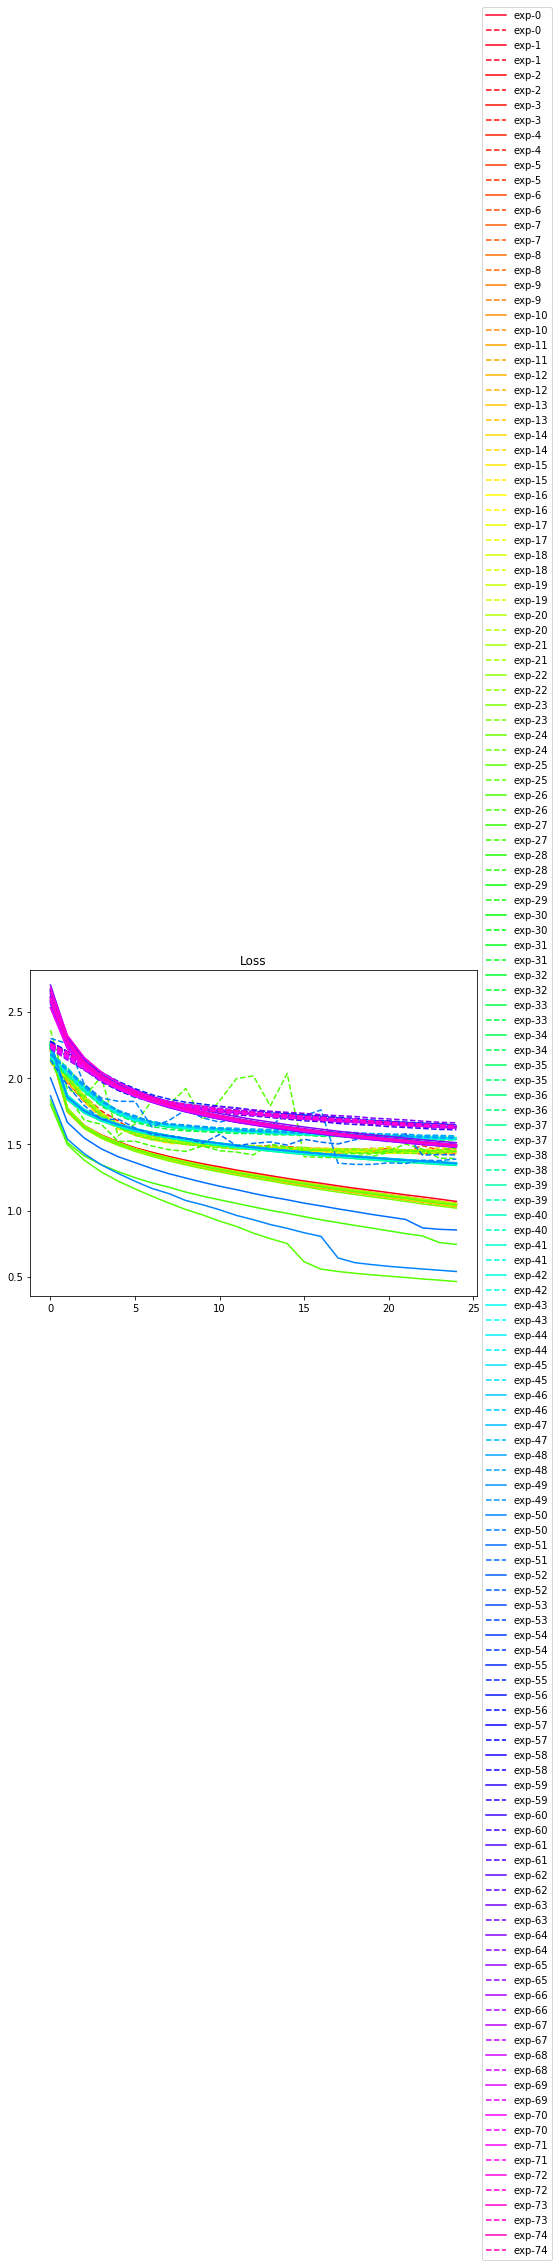

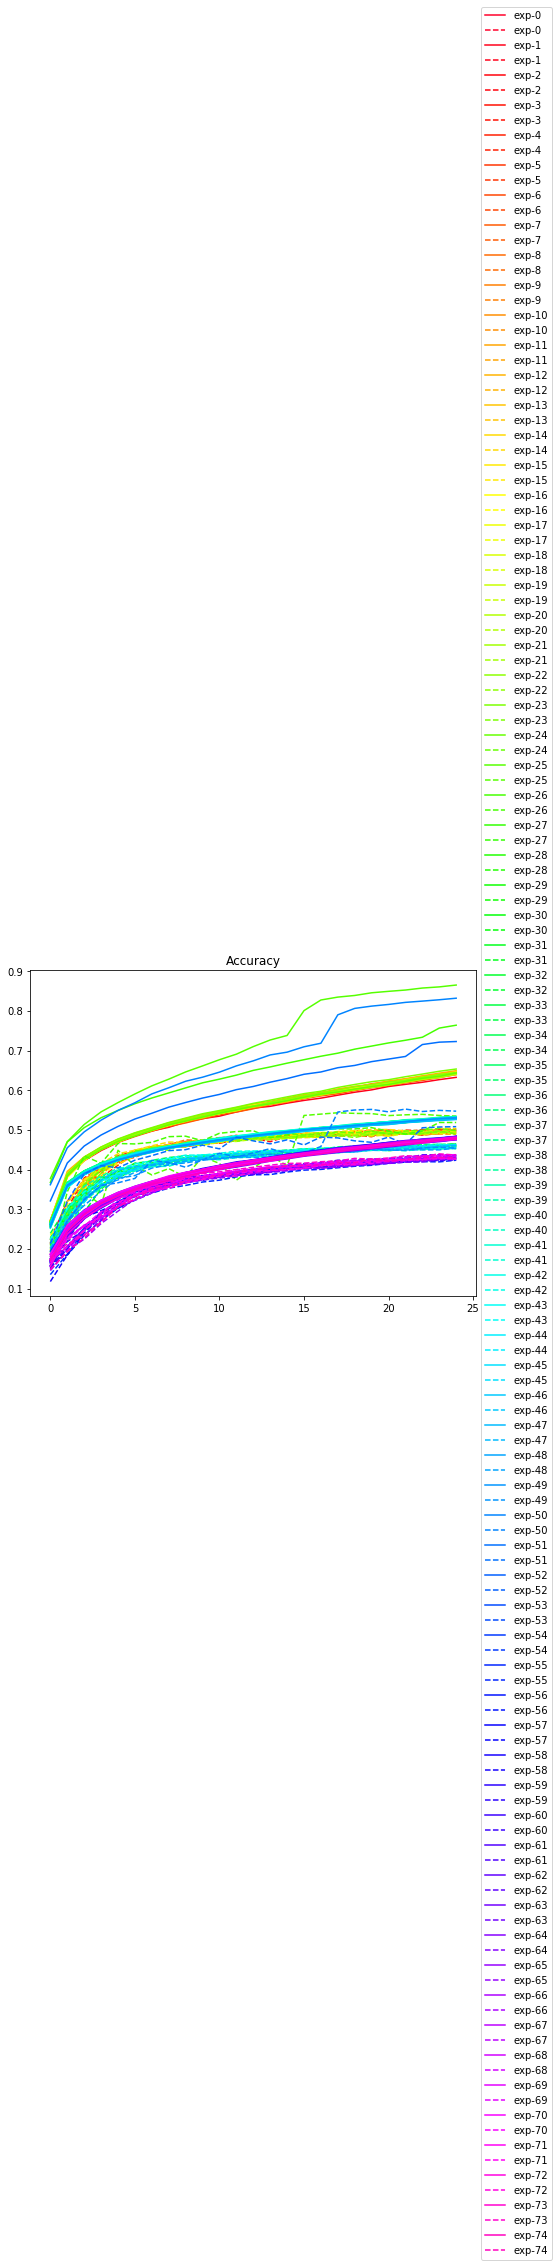

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()